In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Libraries 📚

In [47]:
import numpy as np
import pandas as pd
import time
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#Import local packages
from src.paths.paths import PATHS

## Load data

In [48]:
df = pd.read_csv(PATHS['data_processed']/"picture_data.csv")

In [49]:
df.head()

,url,category,index,filename,Title,Creator,Date Created,External Link,Medium,Object Credit,...,National Museum of Women in the Arts’ Exhibition,Permanent exhibition,Additional Artist Details,Artist Death Place,Commission,Additional Artist Name,Provenance Link,Frame,Original Title (portuguese),Material(s) / Technique(s)
0,https://lh3.googleusercontent.com/ci/AC_FhM8vj...,WHITE,0,0.jpg,"Symphony in White, No. 1 The White Girl",James McNeill Whistler,1862,For more information about this and thousand...,oil on canvas,Harris Whittemore Collection,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://lh3.googleusercontent.com/ci/AC_FhM9fS...,WHITE,1,1.jpg,Summer evening on Skagen Sønderstrand,Peder Severin Krøyer,1893,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://lh3.googleusercontent.com/ci/AC_FhM8fh...,WHITE,2,2.jpg,"Composition with red, yellow and blue",Piet Mondriaan,1927,Collection searcher,Oil on canvas,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://lh3.googleusercontent.com/ci/AC_FhM9VK...,WHITE,3,3.jpg,The Magpie,NaN,1868 - 1869,https//www.musee-orsay.fr/en/collections,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://lh3.googleusercontent.com/ci/AC_FhM9KL...,WHITE,4,4.jpg,The Cradle,NaN,1872,https//www.musee-orsay.fr/en/collections,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Parse to string

In [50]:
df = df.astype('string')
df = df.apply(lambda x: x.str.lower())

# Describe Data

Check the number of columns

In [51]:
print('There are exist:',len(df.columns.to_list()), 'columns')

There are exist: 518 columns


Show the number of null values in each column/feature

<AxesSubplot:ylabel='column'>

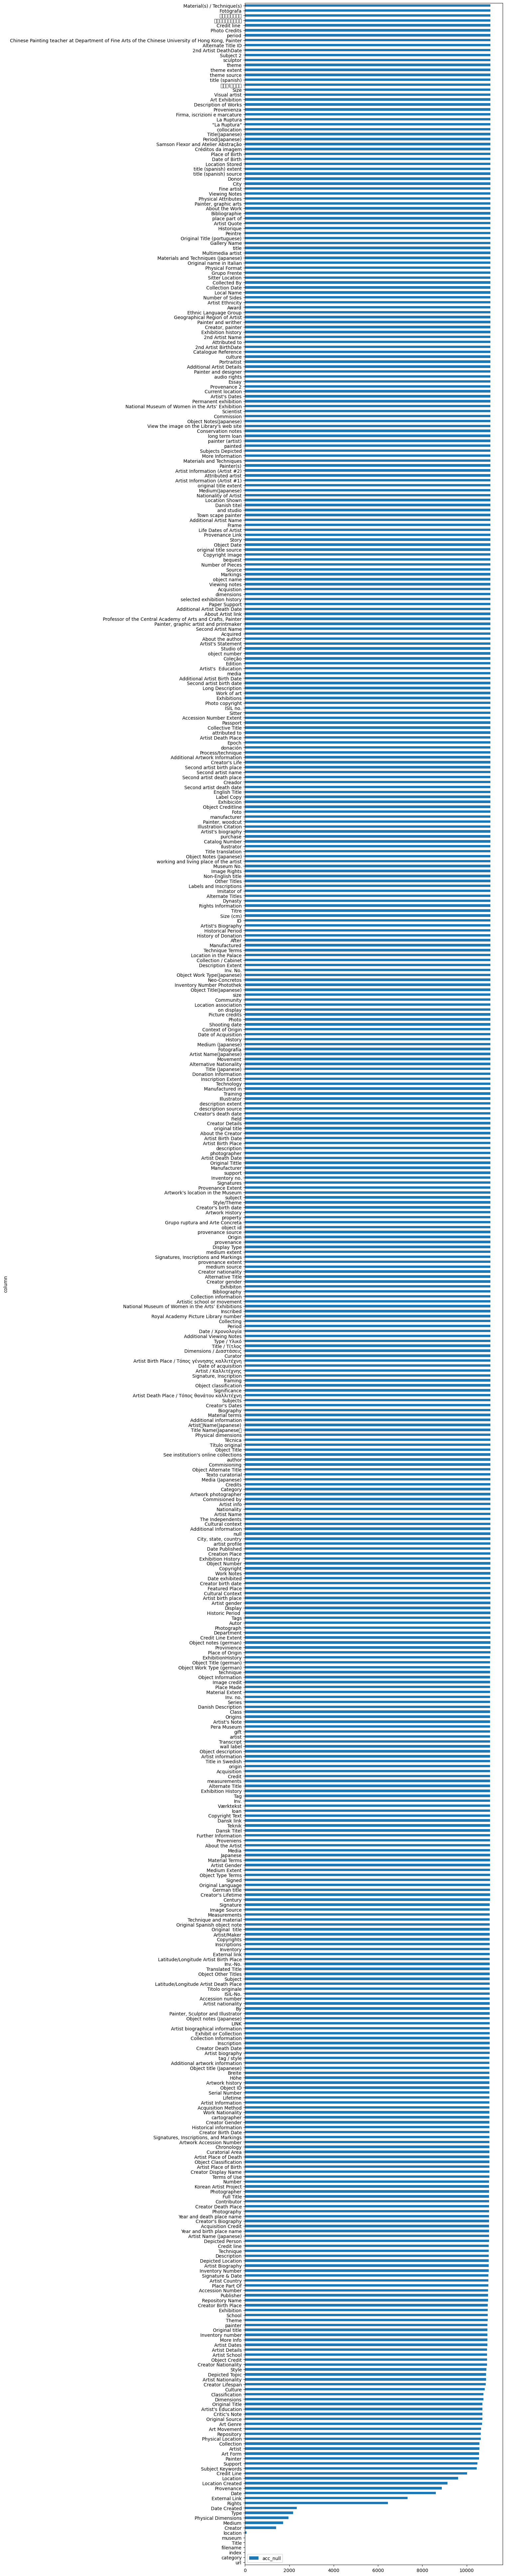

In [52]:

df_nulls = df.isnull().sum().to_frame()
df_nulls.columns = ['acc_null']
df_nulls = df_nulls.sort_values('acc_null')
df_nulls['column'] = df_nulls.index

df_nulls.plot.barh(x='column',y='acc_null', figsize=[10,100])

`Most columns contain only null data` 😥, this will be handled in the next phase

# Cleaning 

#### 1.1 Remove columns that are mostly null

Many columns contain majority **null values**, so...

`only columns with less than 10000 null data will be kept`

In [124]:
junk_columns =df_nulls[df_nulls['acc_null']>10700]['column'].values.tolist()

In [125]:
clean_df =df.drop(junk_columns,axis=1)

Check the remaining columns

In [ ]:
clean_df.isnull().sum()

out of a total of 501 columns only 33 remained

In [127]:
clean_df=clean_df.drop("Location",axis=1)
print()

In [128]:
clean_df.columns =clean_df.columns.str.lower().str.replace(" ","_")



#### 1.2 Get only valuable columns

In the next cases columns will be ignored

**insuficient columns**: columns may be very valuable but do not contain enough data
e.g (`Provenance`)

**worthless columns**: The columns do not represent useful information that aligns with the purpose of the work.
e.g (`Credit Line`)




In [ ]:
clean_df =  clean_df[['url','index','category', 'filename', 'title', 'creator', 'date_created', 'physical_dimensions'
                      ,'painter','date', 'artist','museum','location']]

clean_df.head()

#### 1.3 Mix columns

There are columns that have different names but represent the same information e.g (Creator, Painter and Artist)
So, these columns will be mixed

In [131]:
def join_artist(row):
    if(not pd.isna(row['creator'])):
        return row['creator']
    if(not pd.isna(row['painter'])):
        return row['painter']
    if(not pd.isna(row['artist'])):
        return row['artist']
    return None

def join_date(row):
    if(not pd.isna(row['date_created'])):
        return row['date_created']
    if(not pd.isna(row['date'])):
        return row['date']
    return None



#Mix columns
clean_df['artist'] = clean_df.apply(join_artist, axis=1)
clean_df['date_created'] = clean_df.apply(join_date, axis=1)
clean_df['dimensions'] = clean_df['physical_dimensions']

#Delete duplicated
clean_df = clean_df.drop(['creator','painter','date','physical_dimensions'],axis=1)

In [ ]:
clean_df.head()

In [ ]:
clean_df.info()

Feature reduction is from 501 to 7 , which ensures data quality and low number of nulls in the dataset

#### 1.4 Text Normalization

In [134]:
from src.Regex.Regex import Regex 

regex = Regex()
df_normalize = clean_df.copy()

Normalize date field

In [135]:
df_normalize['date_created'] =df_normalize['date_created'].apply(regex.get_date)

Normalize location field

In [137]:
df_normalize['location'] =df_normalize['location'].apply(regex.get_country)

Normalize dimensions field

In [139]:
#convert dimensions into abbreviations
df_normalize['dimensions'].replace(regex=r'inches', value='in',inplace=True)
df_normalize['dimensions'].replace(regex=r'height', value='h', inplace=True)
df_normalize['dimensions'].replace(regex=r'width', value='w', inplace=True)

#Extract information in dimensions column
df_normalize['width']=df_normalize['dimensions'].apply(regex.get_width)
df_normalize['height']=df_normalize['dimensions'].apply(regex.get_height)
df_normalize['dim']=df_normalize['dimensions'].apply(regex.get_measure)

#Drop dimension column
df_normalize =df_normalize.drop(['dimensions'],axis=1)

df_normalize.head()

,url,index,category,filename,title,date_created,artist,museum,location,width,height,dim
0,https://lh3.googleusercontent.com/ci/ac_fhm8vj...,0,white,0.jpg,"symphony in white, no. 1 the white girl",1862.0,james mcneill whistler,"national gallery of art, washington dc",united states,None,None,None
1,https://lh3.googleusercontent.com/ci/ac_fhm9fs...,1,white,1.jpg,summer evening on skagen sønderstrand,1893.0,peder severin krøyer,skagens museum,denmark,100,150,cm
2,https://lh3.googleusercontent.com/ci/ac_fhm8fh...,2,white,2.jpg,"composition with red, yellow and blue",1927.0,piet mondriaan,the kröller-müller museum,netherlands,40,52,cm
3,https://lh3.googleusercontent.com/ci/ac_fhm9vk...,3,white,3.jpg,the magpie,1868.0,claude monet,"musée d’orsay, paris",france,1300,890,mm
4,https://lh3.googleusercontent.com/ci/ac_fhm9kl...,4,white,4.jpg,the cradle,1872.0,berthe morisot,"musée d’orsay, paris",france,460,560,cm


# 2.0 Feature Extraction

In [140]:
image_files = df_normalize["filename"].values.tolist()
image_files[0:3]

['0.jpg', '1.jpg', '2.jpg']

In [141]:
images = list(map(lambda file: cv2.imread(str(PATHS['data_final_img']/file)), image_files))

In [142]:
def features_extraction(img):
    #Get features in HSV color mode    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    hsv_features = [h.mean()/179,s.mean()/255, v.mean()/255]
    
    #Get features in RGB color mode
    img=img/255
    (b, g, r) = cv2.split(img)
    grayscale = 0.3*r+0.59*g+0.11*b
    rgb_features = [grayscale.mean(), b.mean(), g.mean(),r.mean(),grayscale.std(),b.std(), g.std(),r.std()]
    return [*hsv_features, *rgb_features]
    
    

In [143]:
features = list(map(features_extraction, images))
features_df = pd.DataFrame(features, columns =["h_mean",'s_mean',"v_mean","mean_grayscale", "mean_blue", "mean_green","mean_red","std_grayscale","std_blue", "std_green","std_red"])
features_df.head()

,h_mean,s_mean,v_mean,mean_grayscale,mean_blue,mean_green,mean_red,std_grayscale,std_blue,std_green,std_red
0,0.111021,0.228014,0.759860,0.707468,0.592548,0.702255,0.759860,0.113919,0.112658,0.117957,0.108062
1,0.355944,0.136984,0.745947,0.696685,0.713158,0.700890,0.682375,0.119145,0.071436,0.113651,0.153838
2,0.152400,0.134496,0.874091,0.836621,0.802547,0.829830,0.862469,0.246921,0.279878,0.261812,0.241762
3,0.166317,0.100085,0.706963,0.687141,0.638097,0.687555,0.704309,0.133684,0.122419,0.133433,0.139909
4,0.114576,0.181637,0.627300,0.591144,0.519539,0.586287,0.626952,0.204013,0.186520,0.203947,0.212146


In [145]:
#ToDo: Add id to new dataframes 
df_final = pd.concat([df_normalize,features_df], axis=1)
df_final.sample(5)


,url,index,category,filename,title,date_created,artist,museum,location,width,...,s_mean,v_mean,mean_grayscale,mean_blue,mean_green,mean_red,std_grayscale,std_blue,std_green,std_red
6549,https://lh3.googleusercontent.com/ci/ac_fhm_6r...,6549,orange,6549.jpg,"wi-jún-jon, pigeon's egg head (the light), a ...",1831.0,"george catlin, born wilkes-barre, pa 1796-die...",smithsonian american art museum,united states,29,...,0.542250,0.578444,0.433391,0.239492,0.395810,0.578397,0.160147,0.096100,0.162936,0.222170
2115,https://lh3.googleusercontent.com/ci/ac_fhm_ih...,2115,yellow,2115.jpg,composition with bust,1956.0,spyros papaloukas,b & m theocharakis foundation for the fine art...,greece,82,...,0.220146,0.884002,0.826825,0.699916,0.826958,0.873097,0.093382,0.163181,0.102234,0.085319
865,https://lh3.googleusercontent.com/ci/ac_fhm8_d...,865,white,865.jpg,milan ! water cruise for honeymooners,1965.0,siddhesh,siddhesh memorial foundation for art,india,None,...,0.251028,0.786900,0.716450,0.669192,0.711469,0.743574,0.280899,0.322125,0.292281,0.281659
2568,https://lh3.googleusercontent.com/ci/ac_fhm-xu...,2568,blue,2568.jpg,hurting the word radio #2,1964.0,ed ruscha,hayward gallery,united kingdom,139.7,...,0.753908,0.962447,0.605628,0.843474,0.691108,0.350308,0.068850,0.319943,0.084819,0.258975
1770,https://lh3.googleusercontent.com/ci/ac_fhm8a7...,1770,yellow,1770.jpg,tunisia and libya,1579.0,None,palazzo vecchio museum,italy,111,...,0.650038,0.526315,0.426331,0.174202,0.422977,0.525376,0.207971,0.112722,0.207660,0.258481


In [146]:
df_final.to_csv(PATHS['data_final']/'pictures.csv', index = False)

In [148]:
df_final.isnull().sum()

url                  0
index                0
category             0
filename             0
title                0
date_created       203
artist             487
museum               3
location            77
width             2504
height            2685
dim               2702
h_mean               0
s_mean               0
v_mean               0
mean_grayscale       0
mean_blue            0
mean_green           0
mean_red             0
std_grayscale        0
std_blue             0
std_green            0
std_red              0
dtype: int64